In [101]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import zipfile
import time
import shutil
import statsmodels.api as sm
import seaborn as sns

DATA_ROOT = Path("../data")
output_path = "../data/dsa_processed/discord_cleaned_subset.parquet"

MONTHS = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

# remove columns we don't need for analysis
COLUMNS = [
    "account_type", # can we filter out servers with this?
    "application_date", # When Discord Netherlands B.V. submitted the DSA report.
    "automated_decision", # needed?
    "automated_detection", # proactive vs reactive (whether the content was detected using automated means)
    "decision_ground",  # reason for the decision
    "decision_facts", # more details on the decision, look for keyword server here?
    "category", # violation category, map DSA categories to Discord ones
    "category_specification", # sub category
    "content_type", # The type of content acted on (e.g. text, image, video).
    "content_type_other", # further specification if content_type is "other"
    "content_date", # The date when the content or account was subject to a moderation decision (i.e., the enforcement action date), not when the original content was posted.”
    "source_type", # how the content was identified (e.g. user report, automated detection).
]

CATEGORY_MAPPING = {
    'STATEMENT_CATEGORY_SCAMS_AND_FRAUD': "Scams and Fraud",
    'STATEMENT_CATEGORY_PROTECTION_OF_MINORS': "Protection of minors",                  
    'STATEMENT_CATEGORY_VIOLENCE': "Violence",                                
    'STATEMENT_CATEGORY_CYBER_VIOLENCE': "Cyber Violence",                        
    'STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH': "Illegal or harmful speech",
    'STATEMENT_CATEGORY_RISK_FOR_PUBLIC_SECURITY': "Risk for public security",                 
    'STATEMENT_CATEGORY_OTHER_VIOLATION_TC': "Other violation TC",                       
    'STATEMENT_CATEGORY_SELF_HARM': 'Self harm',   
    'STATEMENT_CATEGORY_INTELLECTUAL_PROPERTY_INFRINGEMENTS': "Intellectual property infringements",
    'STATEMENT_CATEGORY_UNSAFE_AND_PROHIBITED_PRODUCTS': "Unsafe and prohibited products",
    'STATEMENT_CATEGORY_NON_CONSENSUAL_BEHAVIOUR': "Non-consensual behaviour",
    "STATEMENT_CATEGORY_SCOPE_OF_PLATFORM_SERVICE": "Scope of platform service",
    "STATEMENT_CATEGORY_UNSAFE_AND_ILLEGAL_PRODUCTS": "Unsafe and illegal products",
    "STATEMENT_CATEGORY_DATA_PROTECTION_AND_PRIVACY_VIOLATIONS": "Data protection and privacy violations",
    "STATEMENT_CATEGORY_PORNOGRAPHY_OR_SEXUALIZED_CONTENT": "Pornography or sexualized content",
    "STATEMENT_CATEGORY_NEGATIVE_EFFECTS_ON_CIVIC_DISCOURSE_OR_ELECTIONS": "Negative effects on civic discourse or elections",
}

# Data Prep (NOTE: THIS PART CAN TAKE A LONG TIME)

### Download full Discord DSA data

not the most optimal way of achieving this dataset in terms of storage size...

In [11]:
# Base URL of the DSA Transparency Portal
base_url = "https://transparency.dsa.ec.europa.eu/explore-data/download"
platform_id = 59  # Discord
page = 1  # Start from the first page

os.makedirs('../data/dsa_zip_files', exist_ok=True)
os.makedirs('../data/dsa_extracted', exist_ok=True)

def unzip_recursive(folder_path):
    """
    Recursively unzip all zip files in a folder and its subfolders
    """
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".zip"):
                zip_path = os.path.join(root, file)
                extract_folder = os.path.join(root, file.replace(".zip", ""))
                if not os.path.exists(extract_folder):
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_folder)
                    print(f"Extracted {zip_path} -> {extract_folder}")
                    # After extracting, recursively unzip inside
                    unzip_recursive(extract_folder)

def concatenate_csvs(folder_path, output_filename):
    """
    Concatenate all CSVs in a folder (and its subfolders) into a single CSV
    """
    all_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    if all_files:
        df_list = [pd.read_csv(f) for f in all_files]
        combined_df = pd.concat(df_list, ignore_index=True)
        combined_df.to_csv(output_filename, index=False)
        print(f"Concatenated {len(all_files)} CSVs into {output_filename}")
    else:
        print(f"No CSV files found in {folder_path}")

while True:
    print(f"Processing page {page}...")
    params = {"platform_id": platform_id, "page": page}
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all ZIP links in the "full" column
    links = soup.find_all('a', href=True)
    zip_links = [link['href'] for link in links if 'full' in link['href'] and link['href'].endswith('.zip')]
    
    if not zip_links:
        print("No more ZIP files found. Finished downloading all pages.")
        break
    
    for zip_url in zip_links:
        zip_filename = os.path.join('../data/dsa_zip_files', zip_url.split('/')[-1])
        extract_folder = os.path.join('../data/dsa_extracted', zip_url.split('/')[-1].replace('.zip', ''))

        # sanity check
        if not os.path.exists(zip_filename):
            print(f"Downloading {zip_filename}...")
            zip_response = requests.get(zip_url)
            zip_response.raise_for_status()
            with open(zip_filename, 'wb') as f:
                f.write(zip_response.content)
            print(f"Downloaded {zip_filename}")
        else:
            print(f"{zip_filename} already exists. Skipping download.")
        
        if not os.path.exists(extract_folder):
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f"Extracted to {extract_folder}")
        else:
            print(f"{extract_folder} already exists. Skipping extraction.")
        
        # unzip nested zips
        unzip_recursive(extract_folder)
        
        # concatenate data for each day (folder) in a new csv
        output_csv = os.path.join('../data/dsa_extracted', zip_url.split('/')[-1].replace('.zip', '_combined.csv'))
        if(not os.path.exists(output_csv)):
            concatenate_csvs(extract_folder, output_csv)
    
    page += 1
    time.sleep(1)

shutil.rmtree('../data/dsa_zip_files')


Processing page 1...
Downloaded ../data/dsa_zip_files/sor-discord-netherlands-bv-2025-10-28-full.zip
Extracted to ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full
Extracted ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full/sor-discord-netherlands-bv-2025-10-28-full-00006.csv.zip -> ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full/sor-discord-netherlands-bv-2025-10-28-full-00006.csv
Extracted ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full/sor-discord-netherlands-bv-2025-10-28-full-00016.csv.zip -> ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full/sor-discord-netherlands-bv-2025-10-28-full-00016.csv
Extracted ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full/sor-discord-netherlands-bv-2025-10-28-full-00020.csv.zip -> ../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-28-full/sor-discord-netherlands-bv-2025-10-28-full-00020.csv
Extracted ../data/dsa_extracted/sor-discord-netherlands-bv-202

KeyboardInterrupt: 

In [ ]:
os.makedirs('../data/dsa_processed', exist_ok=True)
print("Concatenating all combined CSVs into one big dataset (streaming mode)...")

daily_combined_files = sorted([
    os.path.join('../data/dsa_extracted', f)
    for f in os.listdir('../data/dsa_extracted')
    if f.endswith('_combined.csv')
])

final_output = '../data/dsa_processed/all_discord_data_combined.csv'

# Remove old file if it exists
if os.path.exists(final_output):
    os.remove(final_output)

# Stream-write in chunks
first = True
for fpath in daily_combined_files:
    print(f"Appending {os.path.basename(fpath)} ...")
    for chunk in pd.read_csv(fpath, chunksize=100_000, low_memory=False):
        chunk.to_csv(final_output, mode='a', header=first, index=False)
        first = False

print(f"\nCombined {len(daily_combined_files)} CSV files into {final_output}")

Concatenating all combined CSVs into one big dataset (streaming mode)...
Appending sor-discord-netherlands-bv-2024-07-09-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-10-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-11-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-12-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-13-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-14-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-15-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-16-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-17-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-18-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-19-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-20-full_combined.csv ...
Appending sor-discord-netherlands-bv-2024-07-21-full_combined.csv ...
Appending sor-dis

In [ ]:
# remove directories holding all zip files we dont need anymore
shutil.rmtree('../data/dsa_extracted')

### Filter out relevant columns and combine to parquet file

In [ ]:
path = final_output

df = pd.read_csv(
    path,
    usecols=lambda c: c in COLUMNS,
    dtype=str,          # treat all as strings to speed up parsing
    low_memory=False
)

print(f"Loaded dataframe with shape {df.shape}")

for col in ["content_date", "application_date", "created_at"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

# optimize categorical cols
categorical_cols = [
    "decision_ground",
    "category",
    "automated_detection", "automated_decision"
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("Basic cleaning complete.")
df.to_parquet(output_path, index=False)
print(f"Cleaned + optimized dataset saved to {output_path}")


Loaded dataframe with shape (20623690, 12)
Basic cleaning complete.
Cleaned + optimized dataset saved to ../data/dsa_processed/discord_cleaned_subset.parquet


# Analysis

### Open Parquet dataset

In [76]:
# open parquet dataset
df = pd.read_parquet(output_path)
print(f"Loaded cleaned dataset with shape {df.shape}\n")

# print columns and their types
print("Columns and their data types:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

# reorder dataset based on content_date date
df = df.sort_values(by="content_date", ascending=True)

# find min and max date
date_col = "content_date"
min_date = df[date_col].min()
max_date = df[date_col].max()
print("\nData date range:", min_date, "to", max_date)

Loaded cleaned dataset with shape (20623690, 12)

Columns and their data types:
account_type: object
decision_ground: category
category: category
category_specification: object
content_type: object
content_type_other: object
content_date: datetime64[ns, UTC]
application_date: datetime64[ns, UTC]
decision_facts: object
source_type: object
automated_detection: category
automated_decision: category

Data date range: 2015-06-19 00:00:00+00:00 to 2025-10-28 00:00:00+00:00


### Filter out anything hat is not in the "Other" category (text, media, etc).

In [77]:
df_copy = df.copy()
# DSA started tracking Discord Netherlands B.V. data in 2024
df_copy = df_copy[df_copy["content_date"] >= "2023-01-01"]

# find first and last date in dataframe
min_date = df_copy[date_col].min()
max_date = df_copy[date_col].max()

df_copy = df_copy.dropna(subset=[date_col])

# Content filter (Account & server)
df_copy["content_type"] = df_copy["content_type"].astype(str).str.strip()
df_copy["content_type_other"] = df_copy["content_type_other"].astype(str).str.strip().str.lower()

mask = (
    # (df_copy["content_type"] == "[CONTENT_TYPE_OTHER]") &
    (df_copy["content_type_other"].isin(["user account", "server", "business account"]))
)

filtered_df = df_copy[mask]

filtered_df.head()

,account_type,decision_ground,category,category_specification,content_type,content_type_other,content_date,application_date,decision_facts,source_type,automated_detection,automated_decision
6417169,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_SCAMS_AND_FRAUD,"[""KEYWORD_IMPERSONATION_ACCOUNT_HIJACKING""]","[""CONTENT_TYPE_OTHER""]",user account,2023-01-01 00:00:00+00:00,2025-01-24 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
14280439,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH,"[""KEYWORD_HATE_SPEECH""]","[""CONTENT_TYPE_OTHER""]",user account,2023-01-01 00:00:00+00:00,2025-05-12 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
4711261,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH,"[""KEYWORD_HATE_SPEECH""]","[""CONTENT_TYPE_OTHER""]",user account,2023-01-01 00:00:00+00:00,2024-12-25 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
14226598,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH,"[""KEYWORD_HATE_SPEECH""]","[""CONTENT_TYPE_OTHER""]",user account,2023-01-01 00:00:00+00:00,2025-05-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
14226599,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH,"[""KEYWORD_HATE_SPEECH""]","[""CONTENT_TYPE_OTHER""]",user account,2023-01-01 00:00:00+00:00,2025-05-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED


In [61]:
def summarize_df_columns(df: pd.DataFrame, desc_map: dict | None = None, sample_n: int = 5) -> pd.DataFrame:
    rows = []
    n_rows = len(df)
    for col in df.columns:
        s = df[col]
        n_missing = int(s.isna().sum())
        pct_missing = (n_missing / n_rows) if n_rows else 0

        # safe unique extraction: fall back to stringified values for unhashable items
        try:
            uniques = pd.unique(s.dropna())
        except TypeError:
            uniques = pd.unique(s.dropna().astype(str))

        rows.append({
            "column": col,
            "dtype": str(s.dtype),
            "n_missing": n_missing,
            "pct_missing": pct_missing,
            "n_unique": int(len(uniques)),
            "description": (desc_map or {}).get(col, "")
        })

    out = pd.DataFrame(rows)
    out["pct_missing"] = out["pct_missing"].map(lambda x: f"{x:.1%}")
    return out

summary = summarize_df_columns(filtered_df)
print(summary.to_markdown(index=False))

print("\n")
print(summary.to_latex(index=False))
print("Shape of (raw) dataframe:" , filtered_df.shape)

| column                 | dtype               |   n_missing | pct_missing   |   n_unique | description   |
|:-----------------------|:--------------------|------------:|:--------------|-----------:|:--------------|
| account_type           | object              |    17716663 | 100.0%        |          0 |               |
| decision_ground        | category            |           0 | 0.0%          |          1 |               |
| category               | category            |           0 | 0.0%          |         16 |               |
| category_specification | object              |     1360101 | 7.7%          |         24 |               |
| content_type           | object              |           0 | 0.0%          |          1 |               |
| content_type_other     | object              |           0 | 0.0%          |          1 |               |
| content_date           | datetime64[ns, UTC] |           0 | 0.0%          |       1032 |               |
| application_date       | d

In [79]:
# find min and max date in filtered df
min_date_filtered = filtered_df[date_col].min()
max_date_filtered = filtered_df[date_col].max()
print("\nFiltered Data date range:", min_date_filtered, "to", max_date_filtered)

# find all rows in the frame that have automated_detection as not yes or no
filtered_df = filtered_df[filtered_df['automated_detection'].isin(['yes', 'no', 'Yes', 'No', 'YES', 'NO'])]

# summary = summarize_df_columns(filtered_df)
# print(summary.to_markdown(index=False))

# print("\n")
# print(summary.to_latex(index=False))
print("Shape of (filtered) dataframe:" , filtered_df.shape)


Filtered Data date range: 2023-01-01 00:00:00+00:00 to 2025-07-01 00:00:00+00:00
Shape of (filtered) dataframe: (14741461, 12)


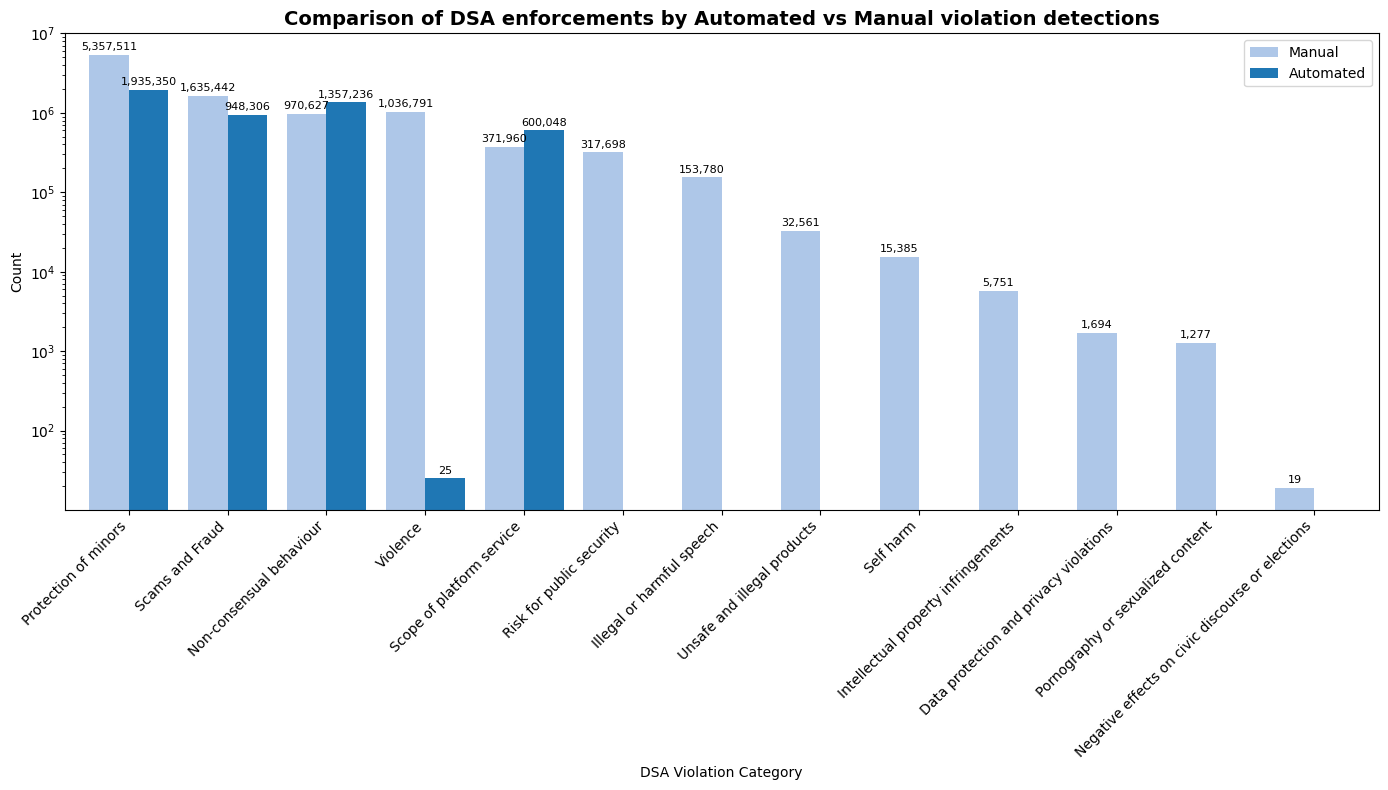

In [95]:
source_df = filtered_df.copy() if not filtered_df.empty else df_copy.copy()

# histogram of automated decision vs manual decision for all categories
cmap = plt.get_cmap('tab20')

# prepare cross-tab of counts
cat_col = 'category'
dec_col = 'automated_detection'
ctab = pd.crosstab(
    source_df[cat_col].astype(str).fillna('Unknown'),
    source_df[dec_col].astype(str).fillna('Unknown')
)

top_idx = ctab.sum(axis=1).sort_values(ascending=False).index
ctab = ctab.loc[top_idx]

# ensure consistent color mapping (use first two colors)
colors = [cmap(0), cmap(1)] if ctab.shape[1] >= 2 else [cmap(0)]

# map each x tick (category) through CATEGORY_MAPPING if available
def map_label(lbl):
    if lbl in CATEGORY_MAPPING:
        return CATEGORY_MAPPING[lbl]
    key = str(lbl).strip()
    if key.upper() in CATEGORY_MAPPING:
        return CATEGORY_MAPPING[key.upper()]
    return key

yes_vals = {"yes", "y", "true", "automated", "automated (proactive)"}

# build colors aligned with ctab.columns so the first color (cmap(0)) is used for automated
cols = list(ctab.columns)
colors = [cmap(0) if str(c).strip().lower() in yes_vals else cmap(1) for c in cols]

fig, ax = plt.subplots(figsize=(14, 8))
ctab.plot(kind='bar', ax=ax, color=colors, width=0.8)

# map legend labels (no title) in the same column order
legend_labels = {col: ('Automated' if str(col).strip().lower() in yes_vals else 'Manual') for col in cols}
ax.legend(labels=[legend_labels[c] for c in cols], title=None)

# Map x tick labels
mapped_labels = [map_label(lbl) for lbl in ctab.index]
ax.set_xticklabels(mapped_labels, rotation=45, ha='right', fontsize=10)

ax.set_yscale("log")
ax.set_ylabel('Count')
ax.set_xlabel("DSA Violation Category")
ax.set_title('Comparison of DSA enforcements by Automated vs Manual violation detections', fontsize=14, weight='bold')

plt.tight_layout()

# Annotate counts
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f"{int(h):,}", (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=8, xytext=(0, 2),
                    textcoords='offset points')

plt.savefig("../img/automated_vs_manual_dsa_enforcements_full.png")
plt.show()


Slope (share per day): 0.000639
Slope (share per year): 0.2333
p-value (slope): 4.27e-181
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1340.
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          4.27e-181
Time:                        13:15:38   Log-Likelihood:                 507.07
No. Observations:                 913   AIC:                            -1010.
Df Residuals:                     911   BIC:                            -1001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Figure size 640x480 with 0 Axes>

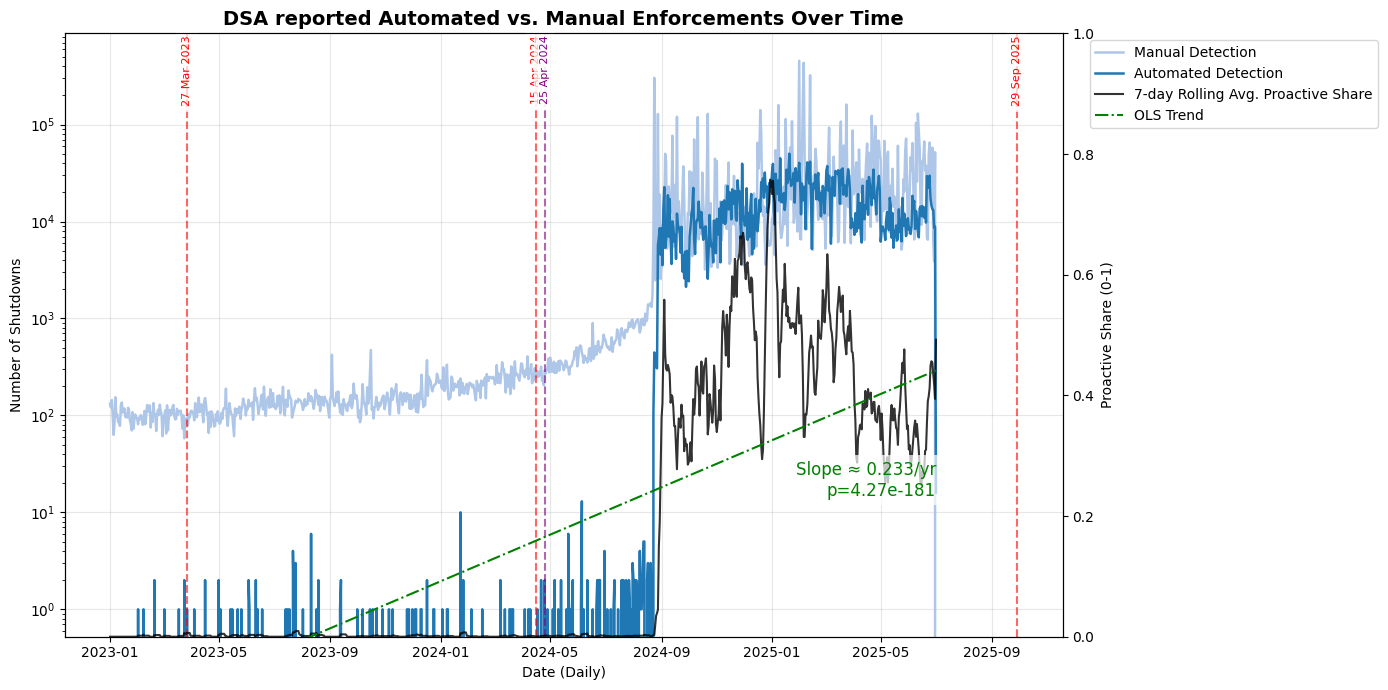

In [90]:
date_col = "content_date"          # use content_date for time axis
detect_col = "automated_detection" # identifies proactive actions ("yes"/"no")
output_file = "../img/dsa_proactive_share_daily.png"

update_dates = ["2023-03-27","2024-04-15", "2025-09-29"]
updates = pd.to_datetime(update_dates)


dsa_vlop = ["2024-04-25"]
vlops = pd.to_datetime(dsa_vlop)

source_df = filtered_df.copy() if not filtered_df.empty else df_copy.copy()

source_df[detect_col] = (
    source_df[detect_col]
    .astype(str)
    .str.lower()
    .map({
        "yes": "Automated (Proactive)",
        "true": "Automated (Proactive)",
        "no": "Manual (Reactive)",
        "false": "Manual (Reactive)"
    })
    .fillna("Unknown")
)

source_df.head()

# line 1 + 2
daily_counts = (
    source_df.groupby([date_col, detect_col])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Ensure both columns exist
for col in ["Automated (Proactive)", "Manual (Reactive)"]:
    if col not in daily_counts.columns:
        daily_counts[col] = 0

# line 3
# 7-DAY ROLLING AVERAGE OF PROACTIVE SHARE
daily_counts["proactive_share"] = (
    daily_counts["Automated (Proactive)"] /
    (daily_counts["Automated (Proactive)"] + daily_counts["Manual (Reactive)"])
).replace([np.inf, -np.inf], np.nan)

daily_counts["proactive_share_7d"] = (
    daily_counts["proactive_share"].rolling(window=7, min_periods=1).mean()
)

plt.clf()
fig, ax = plt.subplots(figsize=(14, 7))

cmap = plt.get_cmap('tab20')
col_pro = cmap(0)         # proactive line color
col_man = cmap(1)         # manual line color
col_event = cmap(3)       # event marker / text color
col_share = "black"       # rolling share line

# plot daily counts
ax.plot(
    daily_counts.index,
    daily_counts["Manual (Reactive)"],
    color=col_man,
    linewidth=1.8,
    label="Manual Detection"
)

ax.plot(
    daily_counts.index,
    daily_counts["Automated (Proactive)"],
    color=col_pro,
    linewidth=1.8,
    label="Automated Detection"
)

ax.set_yscale("log")
ax.set_ylabel("Number of Shutdowns")
ax.set_xlabel("Date (Daily)")

# create secondary y-axis for proactive share
ax2 = ax.twinx()
ax2.plot(
    daily_counts.index,
    daily_counts["proactive_share_7d"],
    color=col_share,
    linewidth=1.5,
    alpha=0.8,
    label="7-day Rolling Avg. Proactive Share"
)
ax2.set_ylabel("Proactive Share (0-1)")
ax2.set_ylim(0, 1)  # ensure y-axis is 0-1

# prepare x (days since first date) and y (drop NA)
times = pd.to_datetime(daily_counts.index)
td = (times - times[0])               # TimedeltaIndex
x_days = td.total_seconds() / 86400  # numpy array of days
y = daily_counts["proactive_share_7d"].to_numpy()

# mask missing y values
mask = ~np.isnan(y)
X = sm.add_constant(x_days[mask])  # intercept + slope
model = sm.OLS(y[mask], X).fit()

slope_per_day = model.params[1]
slope_per_year = slope_per_day * 365.25

print(f"Slope (share per day): {slope_per_day:.6f}")
print(f"Slope (share per year): {slope_per_year:.4f}")
print(f"p-value (slope): {model.pvalues[1]:.4g}")
print(model.summary())

x_fit = x_days
y_fit = model.params[0] + model.params[1] * x_fit  # y = intercept + slope * x

# plot OLS line on secondary axis (proactive share)
ax2.plot(times, y_fit, color="green", linestyle="dashdot", linewidth=1.5, label="OLS Trend")

# annotate slope directly on the line near the end
x_offset = pd.Timedelta(days=0)   # shift 1 days to the right
y_offset = -0.15                  # shift down 

ax2.text(times[-1] + x_offset, y_fit[-1] + y_offset,
         f"Slope ≈ {slope_per_year:.3f}/yr\np={model.pvalues[1]:.3g}",
         va='top', ha='right', fontsize=12,
         color="green", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# event markers on primary axis
for ev in updates:
    ax.axvline(x=ev, color="red", linestyle="--", alpha=0.6)
    ax.text(ev, ax.get_ylim()[1]*0.95, ev.strftime('%d %b %Y'),
            va="top", ha="center", rotation=90, fontsize=8, color="red",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# event markers on primary axis
for ev in vlops:
    ax.axvline(x=ev, color="purple", linestyle="--", alpha=0.6)
    ax.text(ev, ax.get_ylim()[1]*0.95, ev.strftime('%d %b %Y'),
            va="top", ha="center", rotation=90, fontsize=8, color="purple",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
    
# combine legends
lines_labels = [ax.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax.legend(lines, labels, bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_title("DSA reported Automated vs. Manual Enforcements Over Time", fontsize=14, weight="bold")
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(output_file, dpi=300)
plt.show()


Slope (share per day): 0.001206
Slope (share per year): 0.4406
p-value (slope): 1.64e-69
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     446.1
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           1.64e-69
Time:                        13:15:53   Log-Likelihood:                 186.95
No. Observations:                 457   AIC:                            -369.9
Df Residuals:                     455   BIC:                            -361.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

<Figure size 640x480 with 0 Axes>

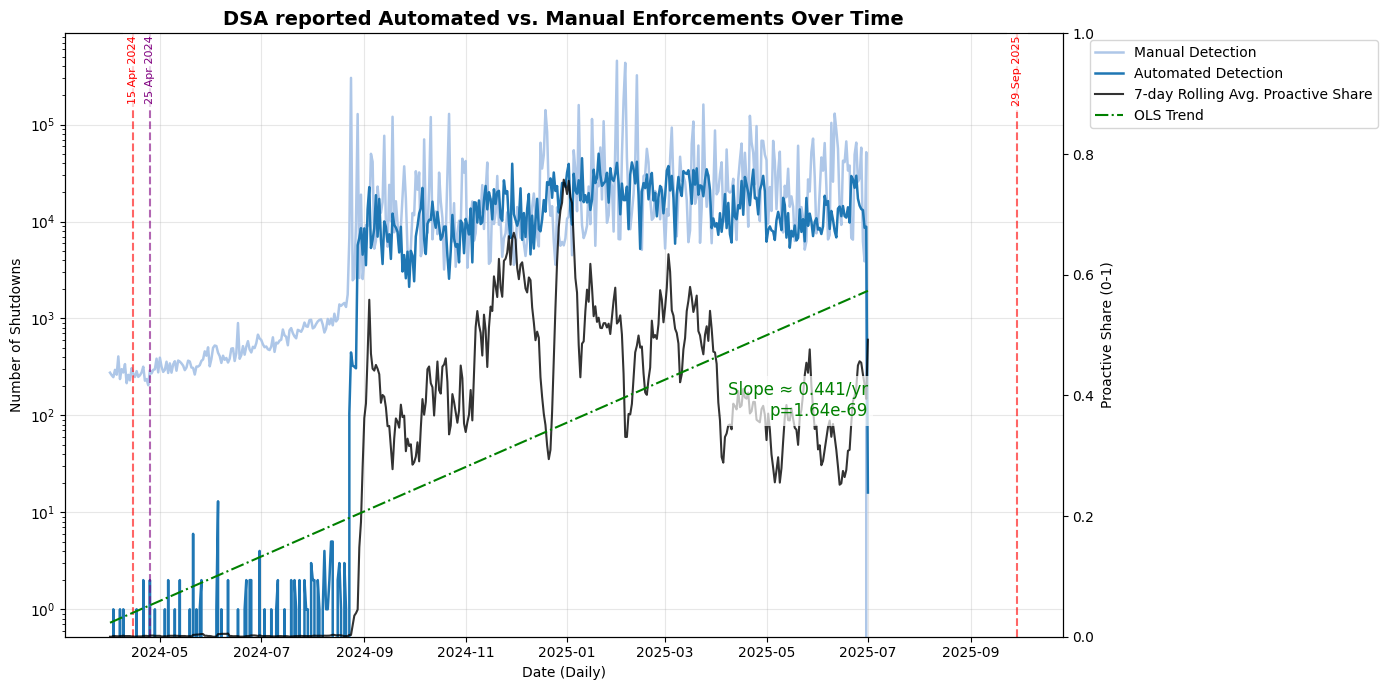

In [91]:
source_df = filtered_df.copy() if not filtered_df.empty else df_copy.copy()

source_df = source_df[source_df["content_date"] >= "2024-04-1"]

date_col = "content_date"          # use content_date for time axis
detect_col = "automated_detection" # identifies proactive actions ("yes"/"no")
output_file = "../img/dsa_zoomed_in.png"

update_dates = ["2024-04-15", "2025-09-29"]
updates = pd.to_datetime(update_dates)

dsa_vlop = ["2024-04-25"]
vlops = pd.to_datetime(dsa_vlop)

source_df[detect_col] = (
    source_df[detect_col]
    .astype(str)
    .str.lower()
    .map({
        "yes": "Automated (Proactive)",
        "true": "Automated (Proactive)",
        "no": "Manual (Reactive)",
        "false": "Manual (Reactive)"
    })
    .fillna("Unknown")
)

# line 1 + 2
daily_counts = (
    source_df.groupby([date_col, detect_col])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Ensure both columns exist
for col in ["Automated (Proactive)", "Manual (Reactive)"]:
    if col not in daily_counts.columns:
        daily_counts[col] = 0

# line 3
# 7-DAY ROLLING AVERAGE OF PROACTIVE SHARE
daily_counts["proactive_share"] = (
    daily_counts["Automated (Proactive)"] /
    (daily_counts["Automated (Proactive)"] + daily_counts["Manual (Reactive)"])
).replace([np.inf, -np.inf], np.nan)

daily_counts["proactive_share_7d"] = (
    daily_counts["proactive_share"].rolling(window=7, min_periods=1).mean()
)

plt.clf()
fig, ax = plt.subplots(figsize=(14, 7))

cmap = plt.get_cmap('tab20')
col_pro = cmap(0)         # proactive line color
col_man = cmap(1)         # manual line color
col_event = cmap(3)       # event marker / text color
col_share = "black"       # rolling share line

# plot daily counts
ax.plot(
    daily_counts.index,
    daily_counts["Manual (Reactive)"],
    color=col_man,
    linewidth=1.8,
    label="Manual Detection"
)

ax.plot(
    daily_counts.index,
    daily_counts["Automated (Proactive)"],
    color=col_pro,
    linewidth=1.8,
    label="Automated Detection"
)

ax.set_yscale("log")
ax.set_ylabel("Number of Shutdowns")
ax.set_xlabel("Date (Daily)")

# create secondary y-axis for proactive share
ax2 = ax.twinx()
ax2.plot(
    daily_counts.index,
    daily_counts["proactive_share_7d"],
    color=col_share,
    linewidth=1.5,
    alpha=0.8,
    label="7-day Rolling Avg. Proactive Share"
)
ax2.set_ylabel("Proactive Share (0-1)")
ax2.set_ylim(0, 1)  # ensure y-axis is 0-1

# prepare x (days since first date) and y (drop NA)
times = pd.to_datetime(daily_counts.index)
td = (times - times[0])               # TimedeltaIndex
x_days = td.total_seconds() / 86400  # numpy array of days
y = daily_counts["proactive_share_7d"].to_numpy()

# mask missing y values
mask = ~np.isnan(y)
X = sm.add_constant(x_days[mask])  # intercept + slope
model = sm.OLS(y[mask], X).fit()

slope_per_day = model.params[1]
slope_per_year = slope_per_day * 365.25

print(f"Slope (share per day): {slope_per_day:.6f}")
print(f"Slope (share per year): {slope_per_year:.4f}")
print(f"p-value (slope): {model.pvalues[1]:.4g}")
print(model.summary())

x_fit = x_days
y_fit = model.params[0] + model.params[1] * x_fit  # y = intercept + slope * x

# plot OLS line on secondary axis (proactive share)
ax2.plot(times, y_fit, color="green", linestyle="dashdot", linewidth=1.5, label="OLS Trend")

# annotate slope directly on the line near the end
x_offset = pd.Timedelta(days=0)   # shift 1 days to the right
y_offset = -0.15                  # shift down 

ax2.text(times[-1] + x_offset, y_fit[-1] + y_offset,
         f"Slope ≈ {slope_per_year:.3f}/yr\np={model.pvalues[1]:.3g}",
         va='top', ha='right', fontsize=12,
         color="green", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# event markers on primary axis
for ev in updates:
    ax.axvline(x=ev, color="red", linestyle="--", alpha=0.6)
    ax.text(ev, ax.get_ylim()[1]*0.95, ev.strftime('%d %b %Y'),
            va="top", ha="center", rotation=90, fontsize=8, color="red",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
    
# event markers on primary axis
for ev in vlops:
    ax.axvline(x=ev, color="purple", linestyle="--", alpha=0.6)
    ax.text(ev, ax.get_ylim()[1]*0.95, ev.strftime('%d %b %Y'),
            va="top", ha="center", rotation=90, fontsize=8, color="purple",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# combine legends
lines_labels = [ax.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax.legend(lines, labels, bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_title("DSA reported Automated vs. Manual Enforcements Over Time", fontsize=14, weight="bold")
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(output_file, dpi=300)
plt.show()

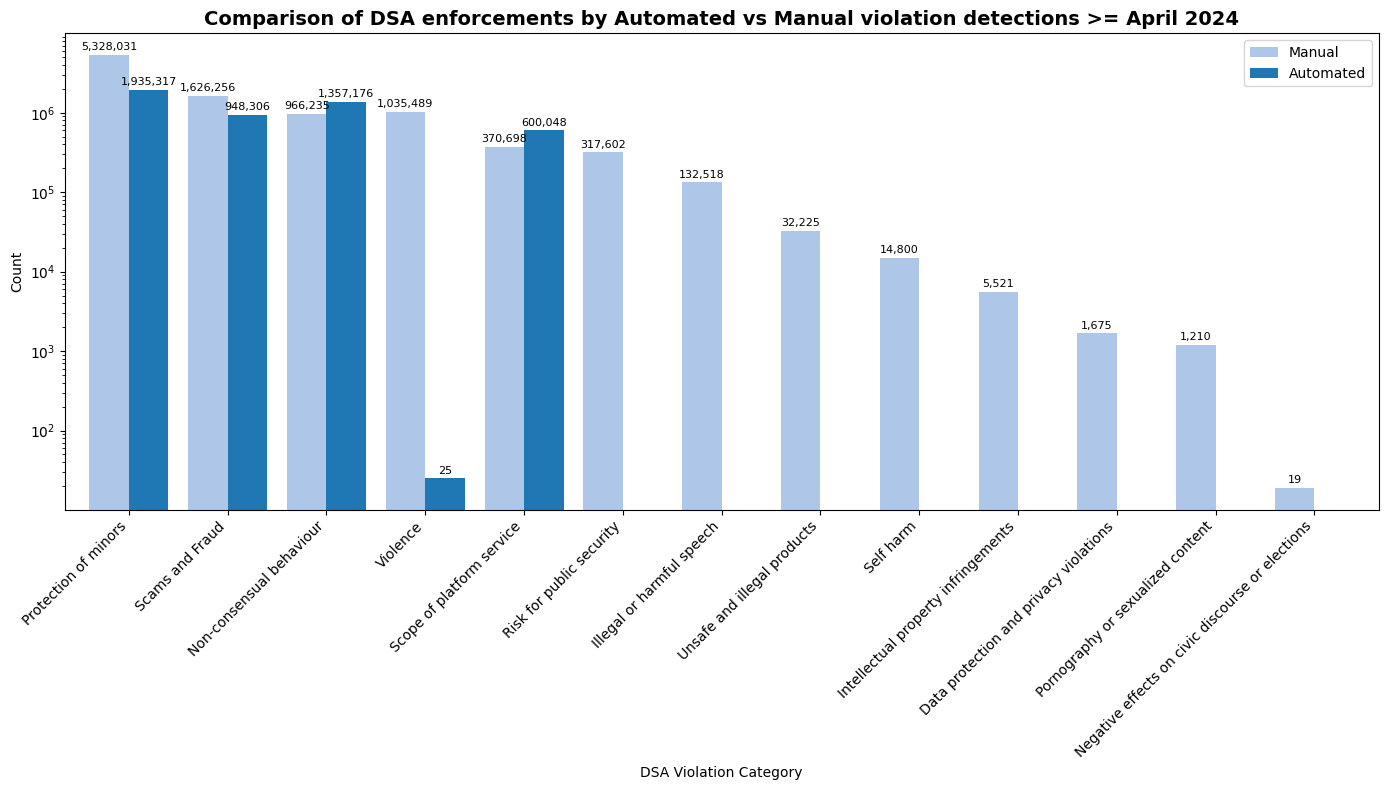

In [96]:
source_df = filtered_df.copy() if not filtered_df.empty else df_copy.copy()

source_df = source_df[source_df["content_date"] >= "2024-04-1"]

# histogram of automated decision vs manual decision for all categories
cmap = plt.get_cmap('tab20')

# prepare cross-tab of counts
cat_col = 'category'
dec_col = 'automated_detection'
ctab = pd.crosstab(
    source_df[cat_col].astype(str).fillna('Unknown'),
    source_df[dec_col].astype(str).fillna('Unknown')
)

top_idx = ctab.sum(axis=1).sort_values(ascending=False).index
ctab = ctab.loc[top_idx]

# ensure consistent color mapping (use first two colors)
colors = [cmap(0), cmap(1)] if ctab.shape[1] >= 2 else [cmap(0)]

# map each x tick (category) through CATEGORY_MAPPING if available
def map_label(lbl):
    if lbl in CATEGORY_MAPPING:
        return CATEGORY_MAPPING[lbl]
    key = str(lbl).strip()
    if key.upper() in CATEGORY_MAPPING:
        return CATEGORY_MAPPING[key.upper()]
    return key

yes_vals = {"yes", "y", "true", "automated", "automated (proactive)"}

# build colors aligned with ctab.columns so the first color (cmap(0)) is used for automated
cols = list(ctab.columns)
colors = [cmap(0) if str(c).strip().lower() in yes_vals else cmap(1) for c in cols]

fig, ax = plt.subplots(figsize=(14, 8))
ctab.plot(kind='bar', ax=ax, color=colors, width=0.8)

# map legend labels (no title) in the same column order
legend_labels = {col: ('Automated' if str(col).strip().lower() in yes_vals else 'Manual') for col in cols}
ax.legend(labels=[legend_labels[c] for c in cols], title=None)

# Map x tick labels
mapped_labels = [map_label(lbl) for lbl in ctab.index]
ax.set_xticklabels(mapped_labels, rotation=45, ha='right', fontsize=10)

ax.set_yscale("log")
ax.set_ylabel('Count')
ax.set_xlabel("DSA Violation Category")
ax.set_title('Comparison of DSA enforcements by Automated vs Manual violation detections >= April 2024', fontsize=14, weight='bold')

plt.tight_layout()

# Annotate counts
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f"{int(h):,}", (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=8, xytext=(0, 2),
                    textcoords='offset points')

plt.savefig("../img/automated_vs_manual_dsa_enforcements.png")
plt.show()


In [100]:
# === Compute mean proactive share by category (DSA, 2024–25) ===

source_df = filtered_df.copy() if not filtered_df.empty else df_copy.copy()
source_df = source_df[source_df["content_date"] >= "2024-04-01"]

# Define columns
cat_col = "category"
dec_col = "automated_detection"

# Normalize detection labels
yes_vals = {"yes", "y", "true", "automated", "automated (proactive)"}
source_df["is_automated"] = source_df[dec_col].astype(str).str.lower().isin(yes_vals)

# Count automated/manual detections by category
agg_counts = (
    source_df.groupby(cat_col)["is_automated"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={True: "Automated", False: "Manual"})
)

# Compute proactive share
agg_counts["Total"] = agg_counts["Automated"] + agg_counts["Manual"]
agg_counts["Proactive_Share"] = agg_counts["Automated"] / agg_counts["Total"]

# Sort descending by proactive share
agg_counts = agg_counts.sort_values("Proactive_Share", ascending=False)

# Map category labels if you have CATEGORY_MAPPING
agg_counts.index = [CATEGORY_MAPPING.get(str(c).upper(), c) for c in agg_counts.index]

# Display in console (optional)
print(agg_counts[["Total","Automated", "Manual", "Proactive_Share"]])

# === Export to LaTeX ===
latex_table = agg_counts[["Total", "Automated", "Manual", "Proactive_Share"]].to_latex(
    index=True,
    caption="Mean Proactive Share by Category (DSA, 2024–25)",
    label="tab:dsa_proactive_share",
    float_format="%.3f",
    column_format="lrrr"
)

# Save LaTeX table
with open("../tables/dsa_proactive_share_by_category.tex", "w") as f:
    f.write(latex_table)

print("\nLaTeX table saved to ../tables/dsa_proactive_share_by_category.tex")


/var/folders/69/6nn2sm8d7qq0p98t_qgp1ckr0000gn/T/ipykernel_63999/2215548351.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  source_df.groupby(cat_col)["is_automated"]


is_automated                                        Total  Automated   Manual  \
Scope of platform service                          970746     600048   370698   
Non-consensual behaviour                          2323411    1357176   966235   
Scams and Fraud                                   2574562     948306  1626256   
Protection of minors                              7263348    1935317  5328031   
Violence                                          1035514         25  1035489   
Data protection and privacy violations               1675          0     1675   
Illegal or harmful speech                          132518          0   132518   
Intellectual property infringements                  5521          0     5521   
Negative effects on civic discourse or elections       19          0       19   
Pornography or sexualized content                    1210          0     1210   
Risk for public security                           317602          0   317602   
Self harm                   

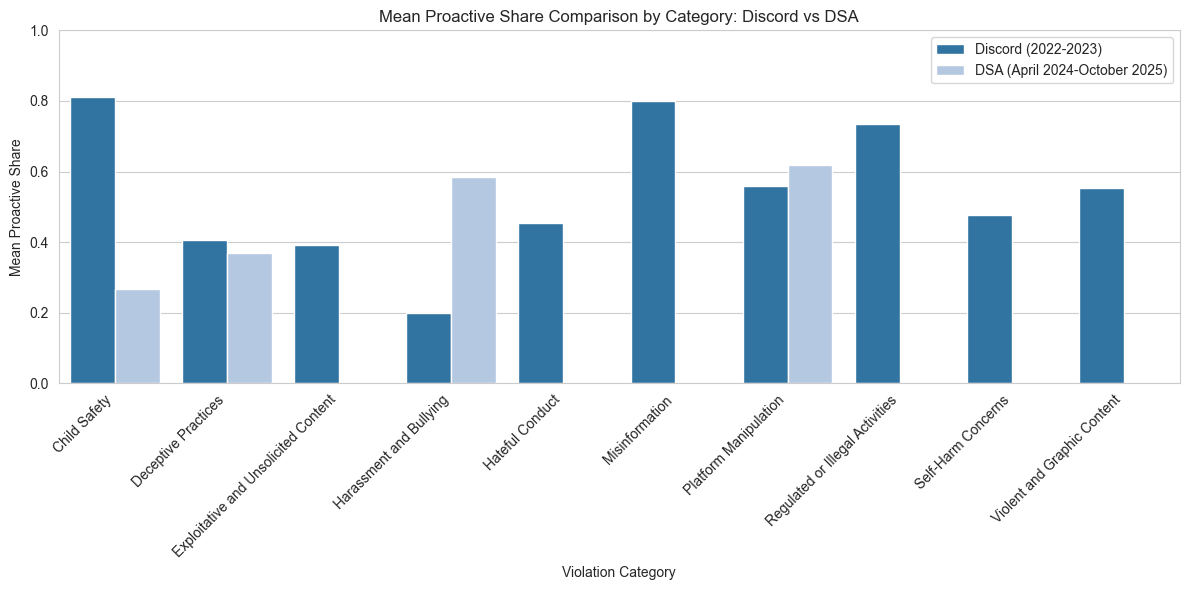

In [111]:
def load_tex_table(filepath):
    """
    Load a LaTeX tabular file into a pandas DataFrame.
    Assumes the table uses & and \\ for columns and rows.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Keep only lines that contain data (skip \toprule, \midrule, \bottomrule, caption, etc.)
    data_lines = [line.strip() for line in lines if '&' in line]

    # Split columns
    rows = []
    for line in data_lines:
        # remove \\ at the end
        line = line.replace('\\\\', '')
        cols = [c.strip() for c in line.split('&')]
        rows.append(cols)

    # Convert to DataFrame
    df = pd.DataFrame(rows[1:], columns=rows[0])
    return df

# Load Discord 2023 and DSA 2024-25 tables
discord_df = load_tex_table('../tables/discord_proactive_share_by_category.tex')
dsa_df = load_tex_table('../tables/dsa_proactive_share_by_category.tex')

# Convert Proactive_Share column to float
discord_df['Proactive_Share'] = discord_df['Proactive_Share'].astype(float)
dsa_df['Proactive_Share'] = dsa_df['Proactive_Share'].astype(float)

# Fill this dictionary with mappings between Discord categories and DSA categories
# Mapping Discord 2023 categories -> DSA 2024–25 categories
category_map = {
    'Child Safety': 'Protection of minors',
    'Misinformation': 'Negative effects on civic discourse or elections',  # approximate
    'Regulated or Illegal Activities': 'Unsafe and illegal products',     # approximate
    'Violent Extremism': 'Violence',
    'Identity and Authenticity': 'Non-consensual behaviour',               # partial match
    'Platform Manipulation': 'Scope of platform service',                 # approximate
    'Violent and Graphic Content': 'Violence',                             # approximate
    'Self-Harm Concerns': 'Self harm',
    'Hateful Conduct': 'Illegal or harmful speech',                        # approximate
    'Deceptive Practices': 'Scams and Fraud',
    'Exploitative and Unsolicited Content': 'Pornography or sexualized content',  # partial
    'Harassment and Bullying': 'Non-consensual behaviour'                  # approximate
}

# Apply mapping to DSA categories
dsa_df['Violation Category Mapped'] = dsa_df['is_automated'].map({v:k for k,v in category_map.items()})
# Keep original if not mapped
dsa_df['Violation Category Mapped'] = dsa_df['Violation Category Mapped'].fillna(dsa_df['is_automated'])

# Also use Discord categories for consistency
discord_df['Violation Category Mapped'] = discord_df['Violation Category']

merged_df = pd.merge(
    discord_df[['Violation Category Mapped','Proactive_Share']],
    dsa_df[['Violation Category Mapped','Proactive_Share']],
    on='Violation Category Mapped',
    how='outer',
    suffixes=('_Discord_2023','_DSA_2024_25')
)

# Melt for seaborn plotting
plot_df = merged_df.melt(
    id_vars='Violation Category Mapped',
    value_vars=['Proactive_Share_Discord_2023','Proactive_Share_DSA_2024_25'],
    var_name='Dataset',
    value_name='Mean Proactive Share'
)

# Clean up Dataset names
plot_df['Dataset'] = plot_df['Dataset'].replace({
    'Proactive_Share_Discord_2023': 'Discord (2022-2023)',
    'Proactive_Share_DSA_2024_25': 'DSA (April 2024-October 2025)'
})

# --- Exclude categories without values in both datasets ---
counts = plot_df.groupby('Violation Category Mapped')['Mean Proactive Share'].count()
valid_categories = counts[counts == 2].index  # only keep categories with 2 entries
plot_df = plot_df[plot_df['Violation Category Mapped'].isin(valid_categories)]

# --- Set up color map ---
cmap = plt.get_cmap('tab20')
colors = [cmap(0), cmap(1)]  # two bars per category

# --- Plot ---
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')

sns.barplot(
    data=plot_df,
    x='Violation Category Mapped',
    y='Mean Proactive Share',
    hue='Dataset',
    palette=colors
)

plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel("Mean Proactive Share")
plt.xlabel("Violation Category")
plt.title("Mean Proactive Share Comparison by Category: Discord vs DSA")
plt.legend(title='')
plt.tight_layout()

plt.savefig("../img/mean_shares_comparison.png")
plt.show()